Traditional approach (unscalable)

In [223]:
words = open('names.txt', 'r').read().splitlines()

In [224]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [225]:
import torch

count = torch.zeros((27,27), dtype=torch.int32)

for word in words:
	chars = ['.'] + list(word) + ['.']
	for c1, c2 in zip(chars, chars[1:]):
		ix1 = stoi[c1]
		ix2 = stoi[c2]
		count[ix1, ix2] += 1

In [226]:
count.shape

torch.Size([27, 27])

(-0.5, 26.5, 26.5, -0.5)

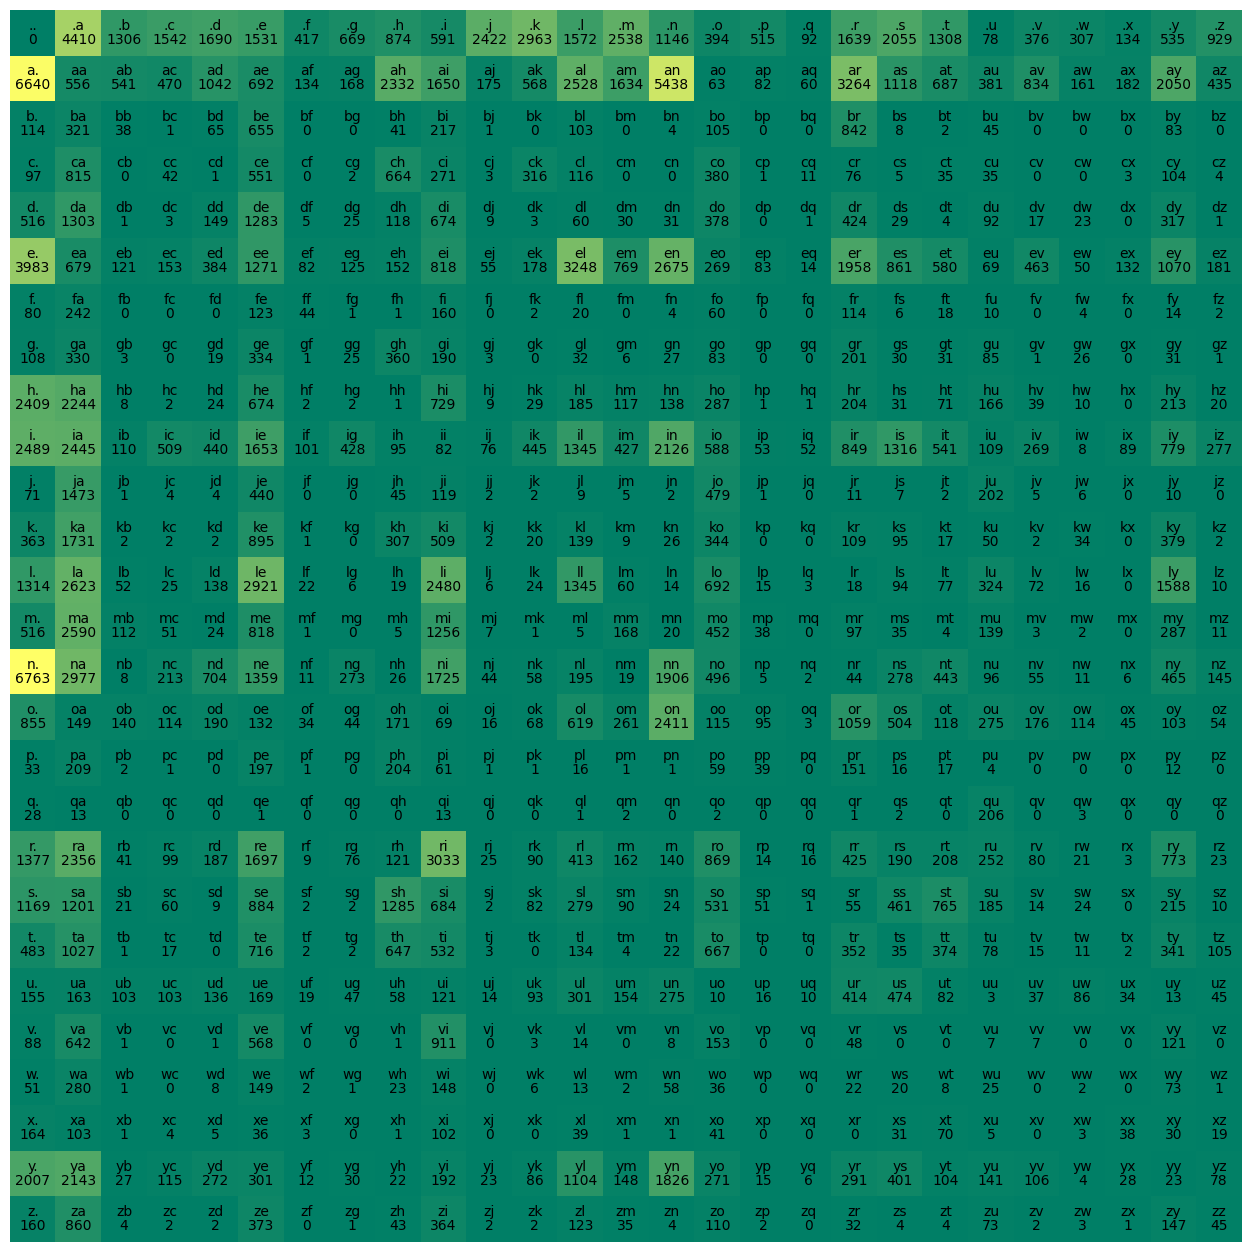

In [227]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(count, cmap='summer')
for i in range(27):
	for j in range(27):
		ch_str = itos[i] + itos[j]
		plt.text(j, i, ch_str, ha='center', va='bottom', color='black')
		plt.text(j, i, count[i, j].item(), ha='center', va='top', color='black')

plt.axis('off')

In [228]:
g = torch.Generator().manual_seed(2147483647)
p = count[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [229]:
# sampling example of one char
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [230]:
probs_old = (count+1).float()
probs_old /= probs_old.sum(dim=1, keepdim=True)

In [231]:
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
	ix = 0
	new_name = ''
	while True:
		p = probs_old[ix].float()
		ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
		new_name += itos[ix]
		if ix == 0:
			break
	print(new_name)	

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [232]:
log_likelihood = 0.0
n = 0
for word in ['andrejq']:
# for word in words[:]:
	chars = ['.'] + list(word) + ['.']
	for c1, c2 in zip(chars, chars[1:]):
		ix1 = stoi[c1]
		ix2 = stoi[c2]
		prob = probs[ix1,ix2]
		logprob = torch.log(prob)
		log_likelihood += logprob
		n += 1
		print(f'{c1}{c2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
neg_log_likelihood = -log_likelihood
print(f'{neg_log_likelihood=}')
print(f'{neg_log_likelihood/n}') # loss function: average negative log likelihood

.a: 0.1342 -2.0085
an: 0.1246 -2.0827
nd: 0.0193 -3.9454
dr: 0.0931 -2.3743
re: 0.0720 -2.6315
ej: 0.0733 -2.6136
jq: 0.0098 -4.6259
q.: 0.1337 -2.0119
log_likelihood=tensor(-22.2938, grad_fn=<AddBackward0>)
neg_log_likelihood=tensor(22.2938, grad_fn=<NegBackward0>)
2.7867214679718018


Linear NN approach (scalable to more than two-character bigrams)

In [243]:
# training set of bigrams
ins, outs = [], []

for word in words:
	chars = ['.'] + list(word) + ['.']
	for c1, c2 in zip(chars, chars[1:]):
		ix1 = stoi[c1]
		ix2 = stoi[c2]
		ins.append(ix1)
		outs.append(ix2)

ins = torch.tensor(ins)
outs = torch.tensor(outs)

print(ins.shape)
print(outs.shape)

torch.Size([228146])
torch.Size([228146])


In [234]:
import torch.nn.functional as F
in_enc = F.one_hot(ins, num_classes=27).float()
W = torch.randn((27,27), requires_grad=True)
(in_enc @ W)[3,13]

tensor(-0.7382, grad_fn=<SelectBackward0>)

In [235]:
(in_enc[3] * W[:,13]).sum()

tensor(-0.7382, grad_fn=<SumBackward0>)

In [236]:
# visualization on most likely next character by the nn
# plt.figure(figsize=(16,16))
# for i in range(probs.shape[0]):
# 	for j in range(27):
# 		plt.text(j, i, itos[j], ha='center', va='center', color='black')
# plt.imshow(probs, cmap='summer')

In [237]:
loss_arr = []
for i in range(100):
	# forward pass
	logits = (in_enc @ W) # log counts
	counts = logits.exp() # undo log counts with exponentiation, equivalent to count matrix
	probs = counts / counts.sum(1, keepdim=True) # normalize counts / softmax
	loss = -probs[torch.arange(ins.nelement()), outs].log().mean() # neg-avg-log-likelihood
	loss += 0.1 * (W**2).mean()
	loss_arr.append(loss)
	# print(f'{loss.item():.4f}')
	# backward pass
	W.grad = None
	loss.backward()
	W.data += -10 * W.grad

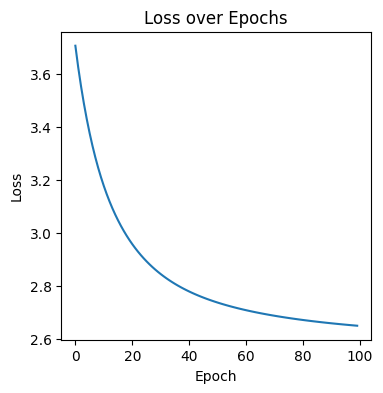

In [238]:
import numpy as np

plt.figure(figsize=(4,4))
epochs = len(loss_arr)
plt.plot(range(epochs), torch.tensor(loss_arr).detach().numpy())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [247]:
# sampling from NN
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
	ix = 0
	new_name = ''
	while True:
		#old probs from trad approach
		# p = probs_old[ix].float()

		# new probs from linear NN
		in_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
		logits = in_enc @ W
		counts = logits.exp()
		p = counts / counts.sum(1, keepdim=True)

		ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
		new_name += itos[ix]
		if ix == 0:
			break
	print(new_name)	

junide.
janaqizhu.
cfqy.
a.
nn.
kshin.
tolian.
jgezvisahnaauyanilevias.
dbdainrwieta.
sniyielylarte.
